# Get the data using these functions:

In [21]:
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)


def load_data(test_size=0.2):
    iris=load_iris()
    X=iris.data
    y=iris.target
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)
    X_train, y_train, X_test, y_test = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)
    return X_train.float(),X_test.float(),y_train,y_test

def get_data_as_dataloaders(train_ds : TensorDataset, test_ds : TensorDataset, batch_size : int):
    return (
        DataLoader(train_ds, batch_size, shuffle=True),
        DataLoader(test_ds, batch_size=batch_size * 2),
    )

# Neural network using nn.Module

In [22]:

import torch.nn as nn       
import torch.nn.functional as F 

class IrisClassifier(nn.Module):
    
    def __init__(self):
        super(IrisClassifier, self).__init__()
        self.layer1 = nn.Linear(4, 120)
        self.layer2 = nn.Linear(120, 64)
        self.layer3 = nn.Linear(64, 12)
        self.layer4 = nn.Linear(12, 3)
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x):
        z = self.ReLU(self.layer1(x))
        z = self.ReLU(self.layer2(z))
        z = self.ReLU(self.layer3(z))
        z = self.ReLU(self.layer4(z))
        z = F.softmax(z, dim=1)
        return z

# Get the model and optimizer using this function

In [23]:

### Get the model

import torch.optim as optim

def get_model_with_optimizer(lr, momentum):
    model = IrisClassifier()
    return model, optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model = IrisClassifier()
opt_fn = optim.SGD()
optimizer = opt_fn(model.parameters(), lr=0.1, momentum=0.9)
print(optimizer)

opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

print(opt)

# 
# 
# 
# 
# DOESNT WORK

# Coding the training loop i.e. the fit() function

### Option 1.1

Inspired from nn.tutorial.ipynb

In [27]:
import numpy as np
import tqdm

def fit(model, epochs, train_dataloader, test_dataloader, optimizer=None, criterion=nn.CrossEntropyLoss()):
    
    train_loss_history=np.zeros((epochs,))
    train_accuracy_history=np.zeros((epochs,))
    test_loss_history=np.zeros((epochs,))
    test_accuracy_history=np.zeros((epochs,))
    
    if optimizer == None: 
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    
    #for epoch in range(epochs):  
    for epoch in tqdm.trange(epochs):
        model.train() # Training the model
        for x_training_batches, y_training_labels in train_dataloader:
            
            output = model(x_training_batches.float())
            loss = criterion(output, y_training_labels)
            
            # Save the loss of the training set at each epoch
            train_loss_history[epoch] += loss.item()
            
            # Zero gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():
                prediction = torch.max(output, 1)[1] # get the index of the max log-probability
                train_accuracy_history[epoch] += float(sum(prediction == y_training_labels)/prediction.shape[0])
        
        model.eval() # Evaluating the model
        for x_test_batches, y_test_labels in test_dataloader:
            with torch.no_grad():
                output = model(x_test_batches)
                loss = criterion(output, y_test_labels)
                test_loss_history[epoch] += loss.item()
                prediction = torch.max(output, 1)[1] # get the index of the max log-probability
                test_accuracy_history[epoch] += float(sum(prediction == y_test_labels)/prediction.shape[0])
                
                
    train_loss_history /= len(train_dataloader)
    train_accuracy_history /= len(train_dataloader)
    test_loss_history /= len(test_dataloader)
    test_accuracy_history /= len(test_dataloader)
    
    return (train_loss_history,
            train_accuracy_history,
            test_loss_history,
            test_accuracy_history)
        
        


### Option 2

Inspired from https://www.cs.toronto.edu/~lczhang/360/lec/w03/nn.html

# Option 2

def train(model, data, batch_size=64, num_epochs=1, criterion = nn.CrossEntropyLoss()):
    train_loader = DataLoader(data, batch_size=batch_size)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    losses, train_acc, val_acc = [], [], []

    # training
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            model.train()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            
            # save the current training information
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            
def get_accuracy(model, train=False):
    if train:
        data = iris_train
    else:
        data = iris_test

    correct = 0
    total = 0
    for imgs, labels in DataLoader(data, batch_size=64):
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

### Option 1.2

Inspired from nn.tutorial.ipynb

import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

### Option 3
From https://medium.datadriveninvestor.com/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7#:~:text=Skorch%20is%20a%20very%20recent,reduction%20of%20the%20boilerplate%20code.

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler
from torchvision import datasets,transforms

DEVICE = torch.device("cpu")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True,transform=transform)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True,transform=transform)
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True)
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        return x
model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion= nn.CrossEntropyLoss()
train_loss_history=[]
val_loss_history=[]
train_acc_history=[]
val_acc_history=[]
num_epochs=10

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
    
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    valid_loss=0.0
    val_correct = 0
    #Validate Model
    model.eval()
    for idx, (images, labels) in enumerate(valid_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    acc = train_correct/len(train_loader.sampler) * 100
    val_acc = val_correct/len(valid_loader.sampler) * 100
    train_loss_history.append(train_loss)
    val_loss_history.append(valid_loss)
    train_acc_history.append(acc)
    val_acc_history.append(val_acc)
    
    print("Epoch:{}/{} \t TL:{:.4f} \t VL:{:.4f} \t TA:{:.2f} %  \t  VA:{:.2f} %".format(epoch+1,num_epochs, 
                                                      train_loss,
                                                      valid_loss,
                                                      acc,
                                                      val_acc))

# Running the model

In [28]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
lr = 0.001
batch_size = 10
epochs = 100
momentum = 0.9

X_train,X_test,y_train,y_test = load_data()
print(X_train.shape)
print(y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader, test_dataloader = get_data_as_dataloaders(train_dataset, test_dataset, batch_size)

model, opt = get_model_with_optimizer(lr, momentum)
loss_function = nn.CrossEntropyLoss()

(train_loss_history,
train_accuracy_history,
test_loss_history,
test_accuracy_history) = fit(model, epochs, train_dataloader, test_dataloader, optimizer=opt, criterion=loss_function)

print(train_accuracy_history[-1])

torch.Size([120, 4])
torch.Size([120])


100%|██████████| 100/100 [00:01<00:00, 54.40it/s]

0.46666667113701504


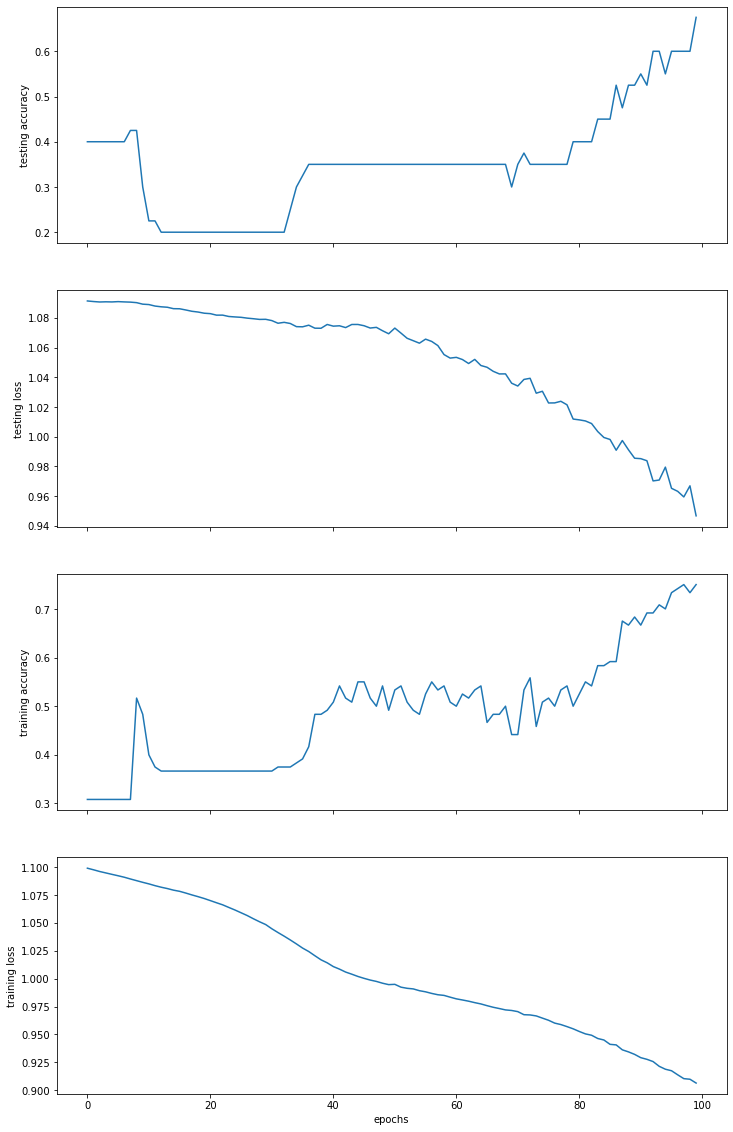

In [26]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 20), sharex=True)

ax1.plot(test_accuracy_history)
ax1.set_ylabel("testing accuracy")
ax2.plot(test_loss_history)
ax2.set_ylabel("testing loss")
ax3.plot(train_accuracy_history)
ax3.set_ylabel("training accuracy")
ax4.plot(train_loss_history)
ax4.set_ylabel("training loss")
ax4.set_xlabel("epochs");